In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [1]:

from autogen_core.models import ChatCompletionClient

# config = {
#     "provider": "OpenAIChatCompletionClient",
#     "config": {
#         "model": "gpt-4o-mini",
#         "api_key": "sk-xxx" # os.environ["...']
#     }
# }

# model_client = ChatCompletionClient.load_component(config)

from autogen_core.models import UserMessage
from autogen_ext.models.openai import OpenAIChatCompletionClient

model_client = OpenAIChatCompletionClient(
    model="qwen2.5",
    base_url="http://localhost:11434/v1",
    api_key="placeholder",
    model_info={
        "vision": False,
        "function_calling": True,
        "json_output": False,
        "family": "unknown",
    },
)

response = await model_client.create([UserMessage(content="What is the capital of France?", source="user")])
print(response)

finish_reason='stop' content='The capital of France is Paris.' usage=RequestUsage(prompt_tokens=36, completion_tokens=8) cached=False logprobs=None


In [4]:

from autogen_ext.models.openai import OpenAIChatCompletionClient

model_client = OpenAIChatCompletionClient(model="gpt-4o-mini")

In [5]:
from autogen_agentchat.agents import AssistantAgent
from autogen_ext.models.openai import OpenAIChatCompletionClient

model_client = OpenAIChatCompletionClient(model="gpt-4o-mini", api_key="sk-xxx", seed=42, temperature=0)

assistant = AssistantAgent(
    name="assistant",
    system_message="You are a helpful assistant.",
    model_client=model_client,
)

In [26]:
from autogen_agentchat.messages import TextMessage
from autogen_agentchat.agents import AssistantAgent
from autogen_core import CancellationToken
from autogen_ext.models.openai import OpenAIChatCompletionClient

model_client = OpenAIChatCompletionClient(model="gpt-4o-mini", seed=42, temperature=0)

assistant = AssistantAgent(
        name="assistant",
        system_message="You are a helpful assistant.",
        model_client=model_client,
    )

cancellation_token = CancellationToken()
response = await assistant.on_messages([TextMessage(content="Hello!", source="user")], cancellation_token)

print(response.chat_message.content)


Hello! How can I assist you today?


In [7]:
# Messages
from autogen_agentchat.messages import TextMessage
text_message = TextMessage(content="Hello, world!", source="User")


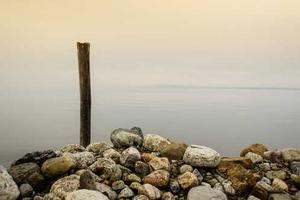

In [8]:
from io import BytesIO

import requests
from autogen_agentchat.messages import MultiModalMessage
from autogen_core import Image as AGImage
from PIL import Image

pil_image = Image.open(BytesIO(requests.get("https://picsum.photos/300/200").content))
img = AGImage(pil_image)
multi_modal_message = MultiModalMessage(content=["Can you describe the content of this image?", img], source="User")
img

In [9]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import TextMessage
from autogen_agentchat.ui import Console
from autogen_core import CancellationToken
from autogen_ext.models.openai import OpenAIChatCompletionClient


# Define a tool that searches the web for information.
async def web_search(query: str) -> str:
    """Find information on the web"""
    return "AutoGen is a programming framework for building multi-agent applications."


# Create an agent that uses the OpenAI GPT-4o model.
model_client = OpenAIChatCompletionClient(
    model="gpt-4o",
    # api_key="YOUR_API_KEY",
)
agent = AssistantAgent(
    name="assistant",
    model_client=model_client,
    tools=[web_search],
    system_message="Use tools to solve tasks.",
)
response = await agent.on_messages(
        [TextMessage(content="Find information on AutoGen", source="user")],
        cancellation_token=CancellationToken(),
    )
print(response.inner_messages)
print(response.chat_message.content)

[ToolCallRequestEvent(source='assistant', models_usage=RequestUsage(prompt_tokens=61, completion_tokens=16), content=[FunctionCall(id='call_iS2UvgeHGiXTwXnsOiSA7VE1', arguments='{"query":"AutoGen"}', name='web_search')], type='ToolCallRequestEvent'), ToolCallExecutionEvent(source='assistant', models_usage=None, content=[FunctionExecutionResult(content='AutoGen is a programming framework for building multi-agent applications.', call_id='call_iS2UvgeHGiXTwXnsOiSA7VE1')], type='ToolCallExecutionEvent')]
AutoGen is a programming framework for building multi-agent applications.


In [10]:
await Console(agent.on_messages_stream(
            [TextMessage(content="Find information on AutoGen", source="user")],
            cancellation_token=CancellationToken(),
        ))

---------- assistant ----------
AutoGen is a programming framework designed for creating multi-agent applications. If you need more details or specific aspects about AutoGen, please let me know!


Response(chat_message=TextMessage(source='assistant', models_usage=RequestUsage(prompt_tokens=108, completion_tokens=32), content='AutoGen is a programming framework designed for creating multi-agent applications. If you need more details or specific aspects about AutoGen, please let me know!', type='TextMessage'), inner_messages=[])

In [20]:
import pandas as pd
from autogen_ext.tools.langchain import LangChainToolAdapter
from langchain_experimental.tools.python.tool import PythonAstREPLTool

df = pd.read_csv("https://raw.githubusercontent.com/pandas-dev/pandas/main/doc/data/titanic.csv")
tool = LangChainToolAdapter(PythonAstREPLTool(locals={"df": df}))
model_client = OpenAIChatCompletionClient(model="gpt-4o-mini")
agent = AssistantAgent(
    "assistant", tools=[tool], model_client=model_client, system_message="Use the `df` variable to access the dataset."
)
await Console(
    agent.on_messages_stream(
        [TextMessage(content="What's the average age of the passengers?", source="user")], CancellationToken()
    )
)

---------- assistant ----------
[FunctionCall(id='call_5J958UwxiBc1IkWuYa3149hZ', arguments='{"query":"df[\'Age\'].mean()"}', name='python_repl_ast')]
---------- assistant ----------
[FunctionExecutionResult(content='29.69911764705882', call_id='call_5J958UwxiBc1IkWuYa3149hZ')]
---------- assistant ----------
29.69911764705882


Response(chat_message=ToolCallSummaryMessage(source='assistant', models_usage=None, content='29.69911764705882', type='ToolCallSummaryMessage'), inner_messages=[ToolCallRequestEvent(source='assistant', models_usage=RequestUsage(prompt_tokens=111, completion_tokens=22), content=[FunctionCall(id='call_5J958UwxiBc1IkWuYa3149hZ', arguments='{"query":"df[\'Age\'].mean()"}', name='python_repl_ast')], type='ToolCallRequestEvent'), ToolCallExecutionEvent(source='assistant', models_usage=None, content=[FunctionExecutionResult(content='29.69911764705882', call_id='call_5J958UwxiBc1IkWuYa3149hZ')], type='ToolCallExecutionEvent')])

In [11]:
await Console(
    agent.on_messages_stream(
        [TextMessage(content="What is Behr's age?", source="user")], CancellationToken()
    )
)

---------- assistant ----------
[FunctionCall(id='call_YXSpot4kDEqCXBX4ZVArcOEy', arguments='{"query": "Behr age"}', name='web_search'), FunctionCall(id='call_I2NrjRpEL0CsolnYQr7Opi48', arguments='{"query": "Behr biography"}', name='web_search')]
---------- assistant ----------
[FunctionExecutionResult(content='AutoGen is a programming framework for building multi-agent applications.', call_id='call_YXSpot4kDEqCXBX4ZVArcOEy'), FunctionExecutionResult(content='AutoGen is a programming framework for building multi-agent applications.', call_id='call_I2NrjRpEL0CsolnYQr7Opi48')]
---------- assistant ----------
AutoGen is a programming framework for building multi-agent applications.
AutoGen is a programming framework for building multi-agent applications.


Response(chat_message=ToolCallSummaryMessage(source='assistant', models_usage=None, content='AutoGen is a programming framework for building multi-agent applications.\nAutoGen is a programming framework for building multi-agent applications.', type='ToolCallSummaryMessage'), inner_messages=[ToolCallRequestEvent(source='assistant', models_usage=RequestUsage(prompt_tokens=156, completion_tokens=49), content=[FunctionCall(id='call_YXSpot4kDEqCXBX4ZVArcOEy', arguments='{"query": "Behr age"}', name='web_search'), FunctionCall(id='call_I2NrjRpEL0CsolnYQr7Opi48', arguments='{"query": "Behr biography"}', name='web_search')], type='ToolCallRequestEvent'), ToolCallExecutionEvent(source='assistant', models_usage=None, content=[FunctionExecutionResult(content='AutoGen is a programming framework for building multi-agent applications.', call_id='call_YXSpot4kDEqCXBX4ZVArcOEy'), FunctionExecutionResult(content='AutoGen is a programming framework for building multi-agent applications.', call_id='call_

In [ ]:
model_client_no_parallel_tool_call = OpenAIChatCompletionClient(
    model="gpt-4o-mini",
    parallel_tool_calls=False,  # type: ignore
)
agent_no_parallel_tool_call = AssistantAgent(
    name="assistant",
    model_client=model_client_no_parallel_tool_call,
    tools=[web_search],
    system_message="Use tools to solve tasks.",
)

In [24]:
from autogen_core.model_context import BufferedChatCompletionContext

# Create an agent that uses only the last 5 messages in the context to generate responses.
agent = AssistantAgent(
    name="assistant",
    model_client=model_client,
    tools=[web_search],
    system_message="Use tools to solve tasks.",
    model_context=BufferedChatCompletionContext(buffer_size=5),  # Only use the last 5 messages in the context.
)

In [25]:
await Console(
    agent.on_messages_stream(
        [TextMessage(content="Prepare notes on Autogen 0.4", source="user")], CancellationToken()
    ) )

---------- assistant ----------
[FunctionCall(id='call_xrvyQdfnXoRgiSwBk6JL0yeI', arguments='{"query":"Autogen 0.4"}', name='web_search')]
---------- assistant ----------
[FunctionExecutionResult(content='AutoGen is a programming framework for building multi-agent applications.', call_id='call_xrvyQdfnXoRgiSwBk6JL0yeI')]
---------- assistant ----------
AutoGen is a programming framework for building multi-agent applications.


Response(chat_message=ToolCallSummaryMessage(source='assistant', models_usage=None, content='AutoGen is a programming framework for building multi-agent applications.', type='ToolCallSummaryMessage'), inner_messages=[ToolCallRequestEvent(source='assistant', models_usage=RequestUsage(prompt_tokens=65, completion_tokens=20), content=[FunctionCall(id='call_xrvyQdfnXoRgiSwBk6JL0yeI', arguments='{"query":"Autogen 0.4"}', name='web_search')], type='ToolCallRequestEvent'), ToolCallExecutionEvent(source='assistant', models_usage=None, content=[FunctionExecutionResult(content='AutoGen is a programming framework for building multi-agent applications.', call_id='call_xrvyQdfnXoRgiSwBk6JL0yeI')], type='ToolCallExecutionEvent')])

In [16]:
from autogen_agentchat.messages import TextMessage
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.ui import Console
from autogen_core import CancellationToken
from autogen_ext.models.openai import OpenAIChatCompletionClient
model_client = OpenAIChatCompletionClient(model="gpt-4o-mini", seed=42, temperature=0)

assistant = AssistantAgent(
        name="assistant",
        system_message="You are a helpful assistant.",
        model_client=model_client,
    )


await Console(assistant.run_stream(task="I am happy."))
# await Console(assistant.on_message_stream("I am happy.",CancellationToken))

---------- user ----------
I am happy.
---------- assistant ----------
That's wonderful to hear! What’s making you feel happy today?


TaskResult(messages=[TextMessage(source='user', models_usage=None, content='I am happy.', type='TextMessage'), TextMessage(source='assistant', models_usage=RequestUsage(prompt_tokens=22, completion_tokens=14), content="That's wonderful to hear! What’s making you feel happy today?", type='TextMessage')], stop_reason=None)